# Biodiversity Monitoring: Design Phase (Part 2)
In this lab you will develop a model for animal classification in the Karoo national park. More specifically, you'll fine tune a Neural Architecture Search Network ([NASNet model](https://arxiv.org/abs/1707.07012)) that was pre-trained on the [ImageNet dataset](https://www.image-net.org/index.php). 


This project contains various folders:

- CameraTraps: Set of tools used by MegaDetector
- ai4eutils: Shared utilities developed by the Microsoft AI for Earth team. Project used by MegaDetector
- yolov5: Open-source AI project for computer vision. Used by MegaDetector
- data: Raw images from the Karoo dataset
- data_crops: Output images from the MegaDetector
- models: Pretrained NASNet model with Karoo dataset

The steps you will complete in this notebook are the following:
1. Import Python packages
2. Try out the original NASNet model
3. Explore data augmentation \
 3.1 Flipping \
 3.2 Zooming \
 3.3 Rotating \
 3.4 Contrasting\
 3.5 Combining different image augmentations 
4. Balance the dataset
5. Create your own model based on NASNet \
 5.1 Load the pre-trained fine-tuned NASNet model \
 5.2 Perform further fine-tuning of the NASNet model (optional)
6. Evaluate your model \
 6.1 Confusion matrix \
 6.2 Visual inspection

## 1. Import Python packages

Run the next cell to import that Python packages you'll need for this lab.

Note the `import utils2` line. This line imports the functions that were specifically written for this lab. If you want to look at what these functions are, go to `File -> Open...` and open the `utils2.py` file to have a look.

In [1]:
import os, sys        # packages to interact with the Operating System
import pandas as pd   # package for reading in and manipulating data
import numpy as np    # package for numerical operations
import matplotlib.pyplot as plt # package to create plots
from IPython.display import Image as IPythonImage  # package to display images in Jupyter

# various packages for neural network model creation and evaluation
import tensorflow as tf 
from tensorflow.keras.metrics import sparse_top_k_categorical_accuracy 
from tensorflow.keras.applications import nasnet

# Set paths for visualization_utils
os.environ['PYTHONPATH'] += ":/home/jovyan/work/ai4eutils"
os.environ['PYTHONPATH'] += ":/home/jovyan/work/CameraTraps"
os.environ['PYTHONPATH'] += ":/home/jovyan/work/yolov5"
sys.path.insert(0, "./ai4eutils")
sys.path.insert(0, "./CameraTraps")
sys.path.insert(0, "./yolov5")

import utils2 # utility functions defined for this lab

# Configure Python to ignore Tensorflow warnings
utils2.ignore_tf_warning_messages()

# Set random seed for reproducibility
RANDOM_SEED = 42
tf.keras.utils.set_random_seed(RANDOM_SEED)

print('All packages imported successfully!')

Using PyTorch version 1.10.1+cu102
All packages imported successfully!


# 2. Try out the original NASNet model

First, let's have a look at how the original model performs. You will be using a NASNet model, which has been pre-trained on ImageNet to classify images into 1000 object categories. NASNet-Mobile is a convolutional neural network that is trained on more than a million images from the ImageNet database. The network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224 pixels with 3 color channels.

<img src='img/nasnet_schema.png'>

Load the NASNet model using the cell below (this may take a few moments).

In [2]:
# Load the pre-trained NASNet model
original_nasnet_model = nasnet.NASNetMobile(include_top=True)
print("NASNet model loaded successfully")

24240128/24227760 [==============================] - 0s 0us/step
NASNet model loaded successfully


Run the next cell to classify images using NASNet mobile. Try it out on a few animals and see how the model does.

In [3]:
# Test image prediction with the pre-trained NASNet model on the Snapshot Karoo dataset
IMAGE_DIR = 'data_crops'
label2cat_full = {i:category for i, category in enumerate(sorted(next(os.walk(f'{IMAGE_DIR}/train'))[1]))}
cat2label_full = {v:k for k,v in label2cat_full.items()}
TEST_DIR = IMAGE_DIR+'/test'
IMAGE_SIZE = (224, 224)
test_imgs = utils2.get_test_imgs(TEST_DIR)

utils2.pick_img_and_plot_predictions(test_imgs, original_nasnet_model, nasnet.decode_predictions, cat2label_full, IMAGE_SIZE)

interactive(children=(Dropdown(description='animal', options=('baboon', 'birdother', 'bustardkori', 'bustardlu…

## 3.  Explore data augmentation

Throughout the next several cells, you'll investigate examples of image augmentation. 

First, run the next cell to load a single batch (32 images) of data.

In [4]:
# Define batch variables
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
OUTPUT_DIR = 'data_final'

# Load in the images as TensorFlow datasets
train_ds_full, _, _ = utils2.load_data(IMAGE_DIR, BATCH_SIZE, IMAGE_SIZE, RANDOM_SEED)

# Load example data
images, labels = next(iter(train_ds_full))
print('examples loaded')

Found 4463 files belonging to 25 classes.
Found 497 files belonging to 25 classes.
Found 1240 files belonging to 25 classes.
examples loaded


Run the next cell to select a single image. You can choose any value from 0 to 31 for the `selected_image` parameter below to look at different examples.

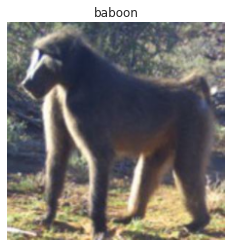

In [5]:
# Select an example image for augmentation (must be a number between 0 and 31)
selected_image = 3

image = images[selected_image].numpy().astype("uint8")
label = label2cat_full[labels[selected_image].numpy()]

utils2.plot_single_image(image, label)

### 3.1 Flipping

Look at the effect of flipping an image horizontally or vertically. You can randomly apply this transformation to a picture, to produce new images for your dataset.

In [6]:
# Augment the image with a flip
utils2.data_aug_flip(image)

interactive(children=(RadioButtons(description='Random Flip', layout=Layout(width='max-content'), options=('ho…

### 3.2 Zooming

Zooming in or out at image is another way to produce new images. 

In [7]:
# Augment the image with a zoom factor
utils2.data_aug_zoom(image)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Zoom: ', max=2.0, min=1.0, …

### 3.3 Rotating

Rotating an image among its center is another way to produce new images

In [8]:
# Augment the image with a rotation
utils2.data_aug_rot(image)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Rotation (deg): ', max=45.0…

### 3.4 Changing contrast

Or changing the contrast to an image can be considered as a new one

In [9]:
# Augment the image with a contrast 
utils2.data_aug_contrast(image)

interactive(children=(FloatSlider(value=1.0, continuous_update=False, description='Contrast factor: ', max=1.5…

### 3.5 Combining different image augmentations
Run the following cell to randomly flip, rotate, contrast, and zoom the input image.  

In [10]:
# Apply a random set of image augmentations
utils2.data_aug_random(image);

interactive(children=(Checkbox(value=True, description='RandomFlip', indent=False), Checkbox(value=False, desc…

## 4. Balance the Dataset

You saw that the original NASNet model doesn't work well on your data. Now, you will use the base of the NASNet model and train a new top for predicting the classes that you have in your dataset. But before you do that, remember that you identified during data exploration that some classes have much more examples than others. So, before moving forward, you will balance the dataset using an `oversampling` and `undersampling` technique. Oversampling consists of creating several copies of the examples from the classes with fewer examples until all categories have the same number of examples. Undersampling means removing data from the classes with more entries until all categories have the same number of images.

In [ ]:
### this cell will take about 4 minutes to run

# Resample the data
utils2.resample_data('data_crops', OUTPUT_DIR, train_ds_full, 11, 500)

# Load in the images as TensorFlow datasets
train_ds, val_ds, test_ds = utils2.load_data(OUTPUT_DIR, BATCH_SIZE, IMAGE_SIZE, RANDOM_SEED)

# Get the labels and categories
label2cat = {i:category for i, category in enumerate(sorted(next(os.walk(f'{OUTPUT_DIR}/train'))[1]))}
cat2label = {v:k for k,v in label2cat.items()}

label2cat

Run the next cell to plot a bar chart of the number of example images in each class before and after resampling

In [ ]:
# Count up the number of example images for each class of animal before and after resampling
count_original = utils2.count_examples_per_class(train_ds_full, label2cat_full, cat2label_full)
count_resampled = utils2.count_examples_per_class(train_ds, label2cat, cat2label)

# Plot the bar charts 
utils2.plot_histograms_of_data(count_original, count_resampled, cat2label, label2cat)

## 5. Create your own model based on NASNet
Now, you will take only the core of the NASNet model and perform additional fine tuning on it. You'll do this by modifying only the final layers of the network. 

In [ ]:
# Load the NASNet pre-trained base model
base_model = nasnet.NASNetMobile(include_top=False)
print("NASNet model loaded successfully")

In [ ]:
# Print out a summary of the NASNet model architecture
base_model.summary()

Now, you must replace the top layers(output) with a fully connected layer having as many outputs as classes you want to train on. Here, you'll restrict the data to only classes which have several dozen images and remove the other classes, leaving you with 11 classes total. 

We also added a pre-processing layer for data augmentation between the input and the NASNet-Mobile Core. During training, the weights of the NASNet-Mobile core won't change(they are frozen). Only the weights of the newly replaced top layers will be updated. This process is called "transfer learning."

<img src='img/nasnet_karoo.png'>

### 5.1 Load the pre-trained fine-tuned NASNet model

Here we have already fine-tuned the pre-trained NASNet model for 150 epochs because fine-tuning in this lab environment would take too long. However, you'll have the option to train for additional epochs below to see what that looks like!

In [ ]:
# Prepare a model for fine tuning
base_model.trainable = False
NUM_CLASSES = 11
model = utils2.get_transfer_model(
    model_to_transfer=base_model,
    num_classes=NUM_CLASSES,
    img_height=IMAGE_SIZE[0],
    img_width=IMAGE_SIZE[1],
)

# Load the fine tuned model weights
model_weight_path = 'models/model_cnn_finetuned_nasnet_150epocha_augmented.h5'
model.load_weights(model_weight_path)

### 5.2 Further fine-tune the NASNet model (optional)

Run the next cell to train for additional epochs if you like. You can change the number of epochs to any number you like but keep in mind it takes about 7 minutes per training epoch in this lab environment.

In [ ]:
# Run additional fine tuning epochs
epochs = 1
history_finetune = model.fit(
    train_ds,
    epochs=epochs
)

Check the training and validation accuracy and loss of the training process. Accuracy should be increasing as your model learns, and loss should decrease as your model makes fewer errors. 

In [ ]:
# Plot the training history for the fine tuning process
utils2.plot_training_history('history_training')

## 6. Model evaluation

Check your fine tuned model's performance on the test set. 

### 6.1 Confusion matrix
With the next two cells you'll generate a confusion matrix to visualize exactly where your model is doing well and where it is having a harder time with classification. 

First, run the next cell to create two lists of the true classes `y_true` and the predicted classes `y_pred` for the test set of data that was not used in training or validation.

In [ ]:
# Create lists for storing the predictions and labels
y_pred = []
y_true = []

# Loop over the data generator
for data, label in test_ds:
    # Make predictions on data using the model. Store the results.
    y_pred.extend(tf.argmax(model.predict(data), axis=1).numpy())
    # Store corresponding labels
    y_true.extend(label.numpy())
# Print out the overall accuracy of the model predictions
print('Overall model accuracy:', np.sum(np.array(y_true) == y_pred)/len(y_pred))

Run the next cell to visualize your confusion matrix.

In [ ]:
# Plot the confusion matrix
utils2.plot_cm(y_true, y_pred, label2cat)

### 6.2 Visual inspection

Run the next cell to select an animal from the dropdown and see your model's predictions. The chart on the right shows your model confidence for the top three predictions, where the confidence bar appears green for the correct prediction.

In [ ]:
# Plot images and the top three model predictions by confidence level
utils2.pick_img_and_plot_predictions(test_imgs, model, label2cat, cat2label, IMAGE_SIZE)

## **Congratulations on finishing this lab!**

**Keep up the good work :)**